# LHII Dimers

In [69]:
import re
import numpy as np
import pandas as pd
import json

pd.set_option('display.max_columns', 10000)  # or 1000
pd.set_option('display.max_rows', 10000)  # or 1000
pd.set_option('display.max_colwidth', 10000)  # or 199

import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update({"font.size" : 22})

import read_gaussian

In [70]:
def get_centre(file_name):
    lines = list(open(file_name))
    
    for line in lines:
        if "Mg" in line:
            return 1.88973 * np.array([float(x) for x in re.findall(r'-?\d+.\d+', line)])

def read_eigenvalues(i, j, frame):
    exciton_lines = list(open(f"Exciton_Bchla_xTB/exciton_bchla_xtb_trunc_bchla_{i}_bchla_{j}_frame_{frame}.out"))
    
    for line in exciton_lines:
        if "eigenvalues" in line:
            eigvals = [float(x) for x in re.findall(r'-?\d+.\d+', line)]
            
            return eigvals
            
def read_bchla_xtb(i, j, frame):
    monomerA = f"monomer_xyzs/trunc_bchla_{i}_frame_{frame}.xyz"
    monomerB = f"monomer_xyzs/trunc_bchla_{j}_frame_{frame}.xyz"
    
    centreA = get_centre(monomerA)
    centreB = get_centre(monomerB)
    
    distance = np.linalg.norm(centreA - centreB)
    
    eigenvalues = read_eigenvalues(i, j, frame)
    
    return distance, eigenvalues

In [80]:
def assign_ring(i):
    ring_assingments = json.load(open("ring_assignment.json"))
    
    return ring_assingments["rings"][f"{i}"]

In [112]:
names = []
monomerAs = []
monomerBs = []
ringAs = []
ringBs = []
frames = []
distances = []
bchla_xtb_ground = []
bchla_xtb_excited1 = []
bchla_xtb_excited2 = []

bchla_xtb_transition1 = []
bchla_xtb_transition2 = []

CAMB3LYP_ground = []
CAMB3LYP_excited1 = []
CAMB3LYP_excited2 = []

CAMB3LYP_transition1 = []
CAMB3LYP_transition2 = []

for frame in [1]:
    for i in range(1, 28):
        for j in range(i, 28):
            
            if(i == j):
                continue
            
            distance, bchla_eigs = read_bchla_xtb(i, j, frame)
            
            CAMB3LYP_result = read_gaussian.read_gaussian(f"CAMB3LYP/CAMB3LYP_trunc_bchla_{i}_bchla_{j}_frame_{frame}.log")
            
            distances.append(distance)
            bchla_xtb_ground.append(bchla_eigs[0])
            bchla_xtb_excited1.append(bchla_eigs[1])
            bchla_xtb_excited2.append(bchla_eigs[2])
            
            bchla_xtb_transition1.append(bchla_eigs[1] - bchla_eigs[0])
            bchla_xtb_transition2.append(bchla_eigs[2] - bchla_eigs[0])
            
            CAMB3LYP_ground.append(CAMB3LYP_result.total_energy)
            CAMB3LYP_excited1.append(CAMB3LYP_result.state_energies[0])
            CAMB3LYP_excited2.append(CAMB3LYP_result.state_energies[1])
            
            CAMB3LYP_transition1.append(CAMB3LYP_result.excitations[0])
            CAMB3LYP_transition2.append(CAMB3LYP_result.excitations[1])

            names.append(f"trunc_bchla_{i}_bchla_{j}_frame_{frame}")
            monomerAs.append(i)
            monomerBs.append(j)
            ringAs.append(assign_ring(i))
            ringBs.append(assign_ring(j))
            
            frames.append(frame)
            
            
LHII_dimers = pd.DataFrame.from_dict({
    "monomer A" : np.array(monomerAs),
    "monomer B" : np.array(monomerBs),
    "ring A" : ringAs,
    "ring B" : ringBs,
    "frame" : np.array(frames),
    "distance" : np.array(distances),
    "bchla_xtb_ground" : np.array(bchla_xtb_ground),
    "bchla_xtb_excited1" : np.array(bchla_xtb_excited1),
    "bchla_xtb_excited2" : np.array(bchla_xtb_excited2),
    "bchla_xtb_transition1" : np.array(bchla_xtb_transition1),
    "bchla_xtb_transition2" : np.array(bchla_xtb_transition2),
    "CAMB3LYP_ground" : np.array(CAMB3LYP_ground),
    "CAMB3LYP_excited1" : np.array(CAMB3LYP_excited1),
    "CAMB3LYP_excited2" : np.array(CAMB3LYP_excited2),
    "CAMB3LYP_transition1" : np.array(CAMB3LYP_transition1),
    "CAMB3LYP_transition2" : np.array(CAMB3LYP_transition2)
})

In [116]:
LHII_dimers.sort_values(by=['CAMB3LYP_transition2'])

,monomer A,monomer B,ring A,ring B,frame,distance,bchla_xtb_ground,bchla_xtb_excited1,bchla_xtb_excited2,bchla_xtb_transition1,bchla_xtb_transition2,CAMB3LYP_ground,CAMB3LYP_excited1,CAMB3LYP_excited2,CAMB3LYP_transition1,CAMB3LYP_transition2
81,4,11,B850a,B800,1,97.254147,-253.163233,-253.100457,-253.098372,0.062776,0.064861,-4069.798978,-4069.738217,-4069.738114,0.060761,0.060864
88,4,18,B850a,B850b,1,102.740303,-253.224845,-253.160177,-253.159984,0.064668,0.064861,-4069.840541,-4069.779780,-4069.779570,0.060761,0.060971
221,11,18,B800,B850b,1,69.833378,-253.126991,-253.064210,-253.062332,0.062781,0.064659,-4069.782451,-4069.721594,-4069.721480,0.060857,0.060971
86,4,16,B850a,B850a,1,95.553145,-253.219982,-253.155120,-253.154471,0.064862,0.065511,-4069.843789,-4069.783027,-4069.782674,0.060761,0.061114
219,11,16,B800,B850a,1,52.569854,-253.122193,-253.059425,-253.056665,0.062768,0.065528,-4069.785762,-4069.724894,-4069.724641,0.060868,0.061121
226,11,23,B800,B800,1,120.790048,-253.135138,-253.072361,-253.069607,0.062777,0.065531,-4069.774820,-4069.713959,-4069.713397,0.060861,0.061423
291,16,23,B850a,B800,1,99.154569,-253.191890,-253.126381,-253.126356,0.065509,0.065534,-4069.819646,-4069.758532,-4069.758223,0.061114,0.061423
93,4,23,B850a,B800,1,83.856721,-253.232983,-253.168122,-253.167454,0.064861,0.065529,-4069.832904,-4069.772143,-4069.771481,0.060761,0.061423
310,18,23,B850b,B800,1,91.759626,-253.196748,-253.132082,-253.131216,0.064666,0.065532,-4069.816391,-4069.755420,-4069.754968,0.060971,0.061423
21,1,23,B850a,B800,1,55.577443,-253.212131,-253.146907,-253.146612,0.065224,0.065519,-4069.812899,-4069.751480,-4069.751168,0.061419,0.061731


## By Distance

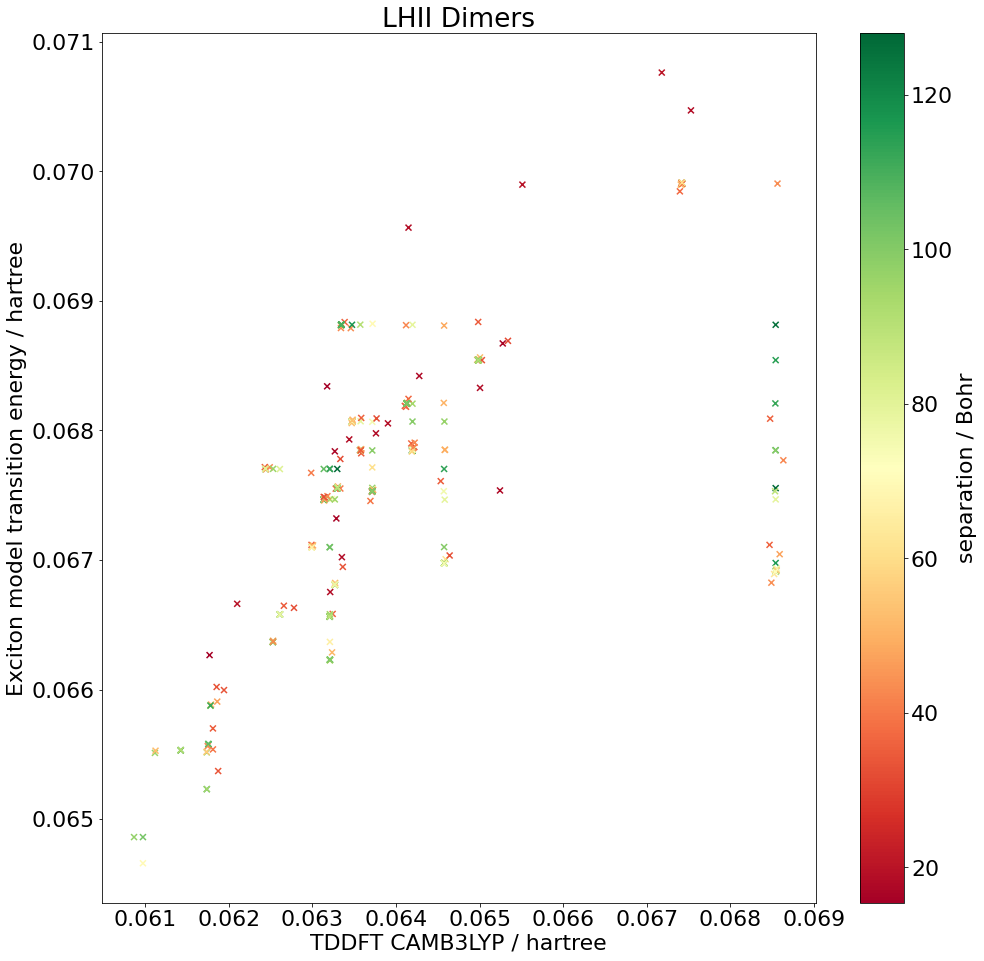

In [117]:
fig, ax = plt.subplots()

all_camb3lyp = LHII_dimers["CAMB3LYP_transition2"]
all_exciton = LHII_dimers["bchla_xtb_transition2"]
all_distances = LHII_dimers["distance"]

#all_camb3lyp = np.concatenate((LHII_dimers["CAMB3LYP_transition1"], LHII_dimers["CAMB3LYP_transition2"]))
#all_exciton = np.concatenate((LHII_dimers["bchla_xtb_transition1"], LHII_dimers["bchla_xtb_transition2"]))
#all_distances = np.concatenate((LHII_dimers["distance"], LHII_dimers["distance"]))

cax = ax.scatter(all_camb3lyp, all_exciton,  c=all_distances, cmap='RdYlGn', marker='x')

ax.set_xlabel("TDDFT CAMB3LYP / hartree")
ax.set_ylabel("Exciton model transition energy / hartree")

cbar = fig.colorbar(cax, ax=ax)
cbar.set_label("separation / Bohr")

ax.set_title("LHII Dimers")

fig.set_size_inches(16, 16)

## Ring interactions

In [118]:
B800_B800 = LHII_dimers.loc[(LHII_dimers["ring A"] == "B800") & (LHII_dimers["ring B"] == "B800")]

B850_B850 = LHII_dimers.loc[(LHII_dimers["ring A"].isin(["B850a", "B850b"])) & (LHII_dimers["ring B"].isin(["B850a", "B850b"]))]

B850_B800 = LHII_dimers.loc[(LHII_dimers["ring A"].isin(["B850a", "B850b"])) & (LHII_dimers["ring B"].isin(["B800"]))]
B800_B850 = LHII_dimers.loc[(LHII_dimers["ring A"].isin(["B800"])) & (LHII_dimers["ring B"].isin(["B850a", "B850b"]))]

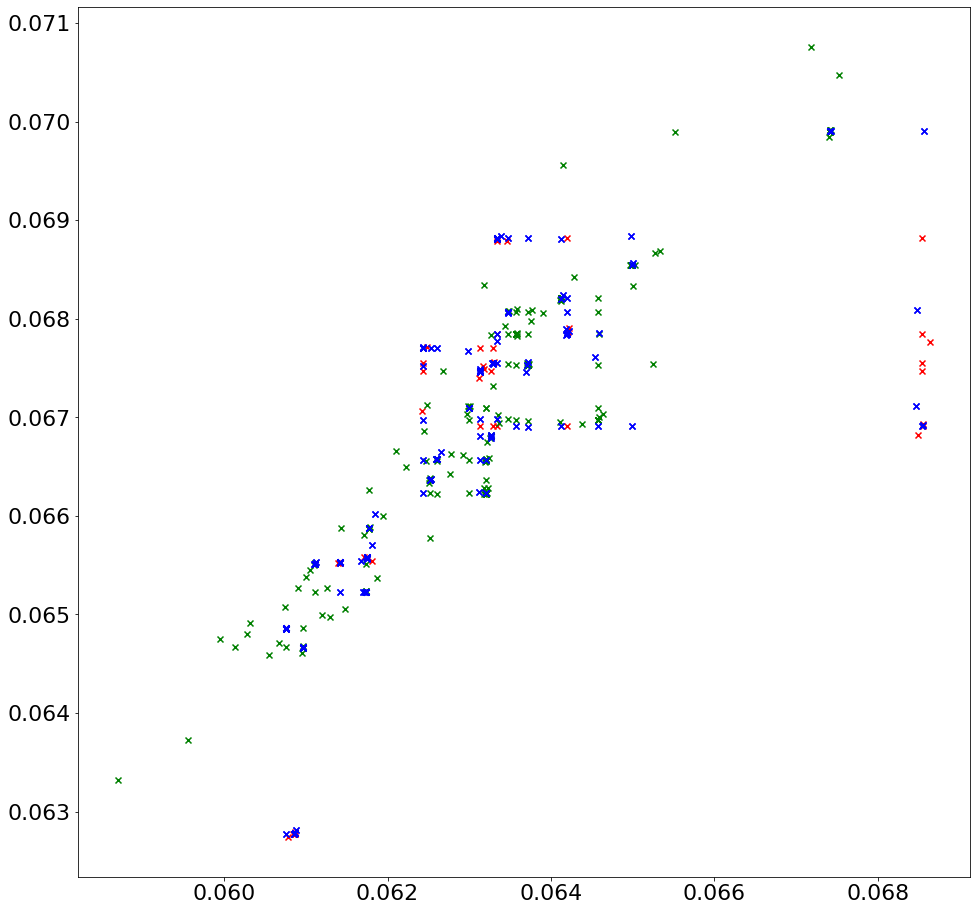

In [123]:
fig, ax = plt.subplots()

ax.scatter(B800_B800["CAMB3LYP_transition1"], B800_B800["bchla_xtb_transition1"], color='red', marker='x')
ax.scatter(B800_B800["CAMB3LYP_transition2"], B800_B800["bchla_xtb_transition2"], color='red', marker='x')

ax.scatter(B850_B850["CAMB3LYP_transition1"], B850_B850["bchla_xtb_transition1"], color='green', marker='x')
ax.scatter(B850_B850["CAMB3LYP_transition2"], B850_B850["bchla_xtb_transition2"], color='green', marker='x')

ax.scatter(B850_B800["CAMB3LYP_transition1"], B850_B800["bchla_xtb_transition1"], color='blue', marker='x')
ax.scatter(B850_B800["CAMB3LYP_transition1"], B850_B800["bchla_xtb_transition1"], color='blue', marker='x')
ax.scatter(B800_B850["CAMB3LYP_transition2"], B800_B850["bchla_xtb_transition2"], color='blue', marker='x')
ax.scatter(B800_B850["CAMB3LYP_transition2"], B800_B850["bchla_xtb_transition2"], color='blue', marker='x')

fig.set_size_inches(16, 16)